# Setup Environment

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import stats

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score, auc, roc_curve,r2_score

from sklearn.model_selection import train_test_split

import random

import matplotlib.pyplot as plt

Tunable hyperparameters

In [2]:
C_VALUES = [0.0001, 0.001, 0.1, 1, 10, 100, 1000,10000]
GAMMA_VALUES = [4.0, 8.0, 16.0, 32.0, 64.0,128.0,256.0,512.0,1024.0]

Import files

In [3]:
HUI_DATA_SPLIT = np.load('/content/data_split.npy',allow_pickle=True)

D_shuffl_20x_512x512_new_blur_10 = np.load('/content/drive/MyDrive/WSIMatrices/20x_512_512_noresize_ShuffleNet_fixed/blur_10/shuffl_20x_512x512_new_blur_10.0.npy')
slides_652 = np.load('/content/drive/MyDrive/WSIMatrices/20x_512_512_noresize_ShuffleNet_fixed/slides_652.npy')

POINT_MUTATION_LABELS_CSV = pd.read_csv('/content/sample_matrix_point_mutation.txt', delimiter = "\t")
POINT_MUTATION_LABELS_CSV['studyID:sampleId'] = POINT_MUTATION_LABELS_CSV['studyID:sampleId'].apply(lambda x: str(x)[29:41])

In [10]:
HUI_DATA_SPLIT

array({'train': ['TCGA-BH-A0BG-01Z-00-DX1', 'TCGA-EW-A1IY-01Z-00-DX1', 'TCGA-BH-A0AY-01Z-00-DX1', 'TCGA-5T-A9QA-01Z-00-DX1', 'TCGA-EW-A2FW-01Z-00-DX1', 'TCGA-AR-A5QP-01Z-00-DX1', 'TCGA-AN-A0XN-01Z-00-DX1', 'TCGA-A2-A04Q-01Z-00-DX1', 'TCGA-A2-A0YL-01Z-00-DX1', 'TCGA-AO-A0J6-01Z-00-DX1', 'TCGA-EW-A1OV-01Z-00-DX1', 'TCGA-BH-A0B5-01Z-00-DX1', 'TCGA-BH-A0HU-01Z-00-DX1', 'TCGA-LD-A7W6-01Z-00-DX1', 'TCGA-BH-A0AZ-01Z-00-DX1', 'TCGA-S3-AA15-01Z-00-DX1', 'TCGA-E9-A5UO-01Z-00-DX1', 'TCGA-BH-A1F8-01Z-00-DX1', 'TCGA-D8-A147-01Z-00-DX1', 'TCGA-C8-A273-01Z-00-DX1', 'TCGA-BH-A18P-01Z-00-DX1', 'TCGA-AO-A03M-01Z-00-DX1', 'TCGA-BH-A0B7-01Z-00-DX1', 'TCGA-BH-A0BV-01Z-00-DX1', 'TCGA-E9-A2JS-01Z-00-DX1', 'TCGA-BH-A0DV-01Z-00-DX1', 'TCGA-GM-A2DD-01Z-00-DX1', 'TCGA-GM-A2D9-01Z-00-DX1', 'TCGA-AO-A0JC-01Z-00-DX1', 'TCGA-E2-A15J-01Z-00-DX1', 'TCGA-BH-A0DQ-01Z-00-DX1', 'TCGA-D8-A1JD-01Z-00-DX2', 'TCGA-E2-A14U-01Z-00-DX1', 'TCGA-AN-A0AR-01Z-00-DX1', 'TCGA-AO-A1KP-01Z-00-DX1', 'TCGA-E2-A14R-01Z-00-DX1', 'TCGA-EW-A1

# SVM

In [8]:
class SVMPredictor:
  def __init__(self,C_values,gamma_values):
    """

        Parameters
        ----------
        C_values : array
            The value for hyperparamter C to test
        gamma_values : array
            The value for hyperparamter gamma to test
    """

    self.Cs = C_values
    self.gammas = gamma_values

  def bootstrap_AUC_CIs(self,probs, labels):
    """Rus bootstrap to generate confidence interval

        Parameters
        ----------
        probs : array
            The prediciton from the decison function of the SVM for each slide
        labels : array
            The labels of the slides
    """

    probs = np.array(probs)
    labels = np.array(labels)
    N_slide = len(probs)
    index_list = np.arange(0, N_slide)
    AUC_list = []
    i = 0
    while i < 1000:
        sampled_indices = random.choices(index_list, k=N_slide)
        sampled_probs = probs[sampled_indices]
        sampled_labels = labels[sampled_indices]

        if np.unique(sampled_labels).size == 1:   # reject the sample if there is only one class
            continue

        auc_bs = roc_auc_score(sampled_labels, sampled_probs)
        AUC_list.append(auc_bs)
        i += 1

    assert len(AUC_list) == 1000
    AUC_list = np.array(AUC_list)
    auc_avg = np.mean(AUC_list)
    auc_CIs = [np.percentile(AUC_list, 2.5), np.percentile(AUC_list, 97.5)]
    return auc_avg, auc_CIs

  def custom_validation(self,D,y,tridx,ttidx,validx):
    """Calucalte pefroemnce of SVM after checking validiation set and generates a ROC curve

        Parameters
        ----------
        D : N * N array
            The MMD distance matrix
        y : array
            labels of each slide : 1 = mutation, 0 = no mutation
        tridx : array
            indices of training set
        ttidx : array 
            indices of test set
        validx : array
            indices of test set
    """
    
    max_C,max_gamma = self.best_hyperparams(self.Cs,self.gammas,D,y,tridx,validx)

    clf = SVC(C = max_C, kernel = 'precomputed',class_weight='balanced')
    K = np.exp(-max_gamma*D)

    K_tr = K[tridx][:,tridx]
    K_tt = K[ttidx][:,tridx]

    y_tr = y[tridx]
    y_tt = y[ttidx]

    clf.fit(K_tr,y_tr)

    z = clf.decision_function(K_tt)

    #plot ROC curve
    svm_fpr, svm_tpr, threshold = roc_curve(y_tt,z)
    auc_svm = auc(svm_fpr,svm_tpr)

    plt.figure(figsize=(5,5), dpi=100)
    plt.plot(svm_fpr, svm_tpr, color="orange",lw=2, linestyle='-', label='ROC Curve (area = %0.4f)' % auc_svm)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    plt.xlabel("False Postive Rate")
    plt.ylabel("True Postive Rate")

    plt.legend()
    plt.savefig("roc_curve.png")
    plt.show()

    auc_avg, auc_CIs = self.bootstrap_AUC_CIs(z,y_tt)
    
    auc_score = roc_auc_score(y_tt,z)

    return auc_score,auc_CIs,max_C,max_gamma

  def best_hyperparams(self,Cs,gammas,D,y,tridx,validx):
    """Picks best C and gamma value for validation set.

        Parameters
        ----------
        Cs : array
            The value for hyperparamter C to test
        gammas : array
            The value for hyperparamter gamma to test
        D : N * N array
            The MMD distance matrix
        y : array
            labels of each slide : 1 = mutation, 0 = no mutation
        tridx : array
            indices of training set
        validx : array
            indices of test set
    """

    max_C = 0
    max_gamma = 0
    max_auc = -np.inf

    for C in Cs:
      clf = SVC(C = C, kernel = 'precomputed',class_weight='balanced')
      for gamma in gammas:
        K = np.exp(-gamma*D)

        K_tr = K[tridx][:,tridx]
        K_va = K[validx][:,tridx]

        y_tr = y[tridx]
        y_va = y[validx]

        clf.fit(K_tr,y_tr)

        z = clf.decision_function(K_va)

        auc_score = roc_auc_score(y_va,z)

        if(auc_score > max_auc):
          max_auc = auc_score
          max_C = C
          max_gamma = gamma
    return max_C,max_gamma

# Train Test Split

In [5]:
class TrainTestSplit:
  def __init__(self,data_split):
    """

        Parameters
        ----------
        data_split : array
            The dictionary of which slides are in train, test, validation sets
    """
    self.data_split = data_split

  def genereate_train_val_test_indicies(self,slides):
    """Finds corresponding indices from a list of slides for the given data split

        Parameters
        ----------
        slides : array
            The list of slide IDs
    """

    train_split = self.data_split.item()['train']
    val_split = self.data_split.item()['val']
    test_split = self.data_split.item()['test']

    tridx_cst = []
    validx_cst = []
    ttidx_cst = []

    for i in train_split:
      if(i[:-11] not in slides):
        continue
      index = np.where(slides == i[:-11])[0][0]
      tridx_cst.append(index)

    for j in val_split:
      if(j[:-11] not in slides):
        continue

      index = np.where(slides == j[:-11])[0][0]
      validx_cst.append(index)

    for k in test_split:
      if(k[:-11] not in slides):
        continue

      index = np.where(slides == k[:-11])[0][0]
      ttidx_cst.append(index)
      
    return tridx_cst,validx_cst,ttidx_cst

# Point Mutation Pred

In [11]:
class PointMutationPrediction:

  def get_point_mutation_labels(self,mutation_type,slides):
    """Get mutation labels for each slide ID

        Parameters
        ----------
        mutation_type : str
            gene that has mutated e.g. 'TP53'
        slides : array
          The list of slide IDs
    """
    
    mutation = POINT_MUTATION_LABELS_CSV[['studyID:sampleId',mutation_type]]
    mutation_filt = mutation.loc[mutation['studyID:sampleId'].isin(slides)]

    order = []
    for slide in slides:
      slide_index = mutation_filt.index[mutation_filt['studyID:sampleId']==slide].tolist()

      if(len(slide_index) == 0):
        raise ValueError('Some label is missing for slide ' + str(slide)) 
      order.append(slide_index[0])

    mutation_filt = mutation_filt.reindex(order)

    y = mutation_filt[mutation_type].to_numpy()
    return y

  def predict_point_mutation(self,slides,D):
    """Predict the point mutation status using an SVM

        Parameters
        ----------
        slides : array
            The list of slide IDs
        D : N * N array
          MMD distance matrix
    """

    y = self.get_point_mutation_labels('TP53',slides)

    tridx_cst,validx_cst,ttidx_cst = TrainTestSplit(HUI_DATA_SPLIT).genereate_train_val_test_indicies(slides)

    unique, counts = np.unique(y, return_counts=True)
    label_dict = dict(zip(unique, counts))
    negative = label_dict[0]
    positive = label_dict[1]
    neg_pos = '(' + str(negative) + ',' + str(positive) + ')'

    auc, auc_CIs,max_C,max_gamma = SVMPredictor(C_VALUES,GAMMA_VALUES).custom_validation(
                                 D=D,
                                 y=y,
                                 tridx=tridx_cst,
                                 ttidx=ttidx_cst,
                                 validx=validx_cst
                                 )
    
    interval = str(round(auc_CIs[0],4)) + '-' + str(round(auc_CIs[1],4))
    entry_MMD = str(round(auc,4)) + ' (' + interval + ')'
      
    return {'gene':'TP53','-/+':neg_pos,'C':max_C,'gamma':max_gamma,'AUCROC (CI)':entry_MMD}


# Prediciton

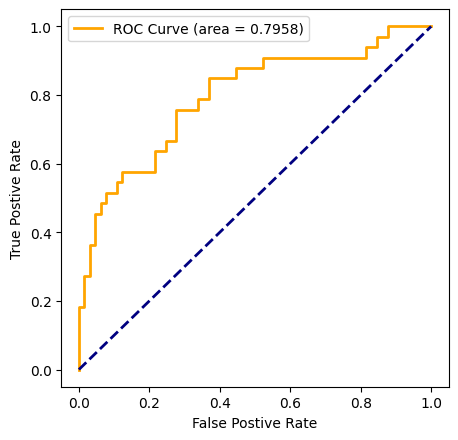

{'gene': 'TP53',
 '-/+': '(417,235)',
 'C': 10000,
 'gamma': 4.0,
 'AUCROC (CI)': '0.7958 (0.6919-0.8861)'}

In [12]:
PointMutationPrediction().predict_point_mutation(slides_652,D_shuffl_20x_512x512_new_blur_10)